# **Logistic Regression Model - 1 Year of Data**

## Import Libraries

In [2]:
import numpy as np
import itertools
from plotly import express as px
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, fixed
from sklearn.model_selection import train_test_split
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##The Model

In [10]:
# Define the Sigmoid function

def sigmoid(z):
  s = 1 / (1 + np.exp(-z))
  return s


# Define a function for initializing parameters
def initialize_zeros(dim):
  w = np.zeros((dim,1))
  b = float(0)

  return w, b


# Define function for forward and backward propagation
def propagation(w, b, X, y):
  m = X.shape[1]

  # Forward propagation

  # Activation function:
  A = sigmoid(np.dot(w.T, X) + b)

  # Compute cost:
  cost = (-1 / m) * (np.dot(y, np.log(A).T) + np.dot((1 - y), np.log(1 - A).T))

  # Backward propagation
  dw = (1/m) * np.dot(X, (A-y).T)
  db = (1/m) * np.sum(A-y)

  cost = np.squeeze(np.array(cost))

  gradients = {"dw": dw,
           "db": db}

  return gradients, cost


# Define function for gradient descent to update parameters
def gradient_descent(w, b, X, y, iterations, learning_rate, print_cost=False):
  w = copy.deepcopy(w)
  b = copy.deepcopy(b)

  costs = []

  for i in range(iterations):
    gradients, cost = propagation(w, b, X, y)
    dw = gradients["dw"]
    db = gradients["db"]

    w = w - learning_rate * dw
    b = b - learning_rate * db

    #if i % 100 == 0:
    costs.append(cost)

    if print_cost:
      print("Cost after iteration %i: %f" %(i, cost))

  parameters = {"w": w,
                "b": b}

  gradients = {"dw": dw,
               "db": db}

  return parameters, gradients, costs


# Define function for prediction
def predict(w, b, X):
  m = X.shape[1]
  Y_prediction = np.zeros((1,m))
  w = w.reshape(X.shape[0], 1)
  A = sigmoid(np.dot(w.T, X) + b)

  for i in range(A.shape[1]):
    Y_prediction[0, i] = A[0, i]

  return Y_prediction

# Define function for model with all functions defined above
def model(X, y, X_test_normalized, y_test_normalized, iterations, learning_rate, print_cost=False, plot_iterations=False):
  w_0, b_0 = initialize_zeros(X.shape[0])


  parameters, gradients, costs = gradient_descent(w_0, b_0, X, y, iterations, learning_rate)

  w = parameters["w"]
  b = parameters["b"]

  Y_prediction_test = predict(w, b, X_test_normalized)
  Y_prediction_train = predict(w, b, X)

  if print_cost:
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - y)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - y_test_normalized)) * 100))

  result = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "iterations": iterations}

  return result

##Cleaning the Data

In [11]:
input_data = pd.read_csv('/content/drive/MyDrive/Malmo_Data_3years.csv', thousands=',')

USE_YEARS = [2019] # enter the years wanted in the dataset

input_data["datetime"] = pd.to_datetime(input_data['datetime'])
input_data['year'] = input_data['datetime'].dt.year
input_data['day of year'] = input_data['datetime'].dt.dayofyear
input_data['hour'] = input_data['datetime'].dt.hour

cols = input_data.columns.tolist()
cols = cols[-3:] + cols[2:-3] # add year, day and hour first - removes city and datetime column
input_data = input_data[cols]
input_data = input_data[input_data['year'].isin(USE_YEARS)]
input_data.describe()

,year,day of year,hour,temp [°C],humidity [%],precip [mm],wind speed [kph],wind dir [°],cloudcover [%],solar radiation [W/m2],electricity [kW]
count,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8753.000000,8760.000000
mean,2019.0,183.023973,11.500000,10.257979,79.557194,0.070466,11.938425,208.196393,55.946267,76.000640,0.132075
std,0.0,105.374771,6.922582,6.750511,15.862958,0.364796,6.373720,91.406913,40.299842,141.576149,0.217063
min,2019.0,1.000000,0.000000,-5.000000,20.470000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2019.0,92.000000,5.750000,5.100000,69.897500,0.000000,7.500000,130.000000,10.000000,0.000000,0.000000
50%,2019.0,183.000000,11.500000,9.300000,83.860000,0.000000,11.400000,232.000000,66.100000,6.000000,0.000000
75%,2019.0,274.000000,17.250000,15.300000,92.570000,0.000000,15.700000,279.000000,96.400000,78.000000,0.184250
max,2019.0,365.000000,23.000000,30.400000,100.000000,17.827000,44.300000,360.000000,100.000000,838.000000,0.844000


##Handle Missing Data

In [12]:
# Handle the missing data
coordinates_of_NaN = np.where(input_data.isna())
row_col_of_NaN = np.array([(int(x), input_data.columns[y]) for x, y in zip(coordinates_of_NaN[0], coordinates_of_NaN[1])])

print(row_col_of_NaN)

rows_to_access = row_col_of_NaN[:,0].astype(int).tolist()
columns_to_impute = list(set(row_col_of_NaN[:,1].flatten()))

for column_to_impute in columns_to_impute:
  if column_to_impute == 'solar radiation [W/m2]':
  # this needs to be done per "column to impute"
    temp_df = pd.DataFrame()
    temp_df['ffill'] = input_data[column_to_impute].fillna(method='ffill')
    temp_df['bfill'] = input_data[column_to_impute].fillna(method='bfill')
    temp_df['meanfill'] = temp_df.mean(axis=1)
    temp_df['solar_radiation_NaN_filled'] = input_data[column_to_impute].fillna(temp_df.pop('meanfill'))
    temp_df['solar_radiation_filled_rolled'] = temp_df['solar_radiation_NaN_filled'].rolling(7, center=True, min_periods=1).mean() # sliding window (rolling mean)
    temp_df['imputed_solar_radiation'] = input_data[column_to_impute].fillna(temp_df.pop('solar_radiation_filled_rolled'))

    values_to_access = temp_df.loc[rows_to_access] # to verify the fill

    input_data[column_to_impute] = temp_df['imputed_solar_radiation']
  else:
    print(column_to_impute, "has no fill method implemented")


X = input_data[['year', 'day of year', 'hour', 'temp [°C]', 'humidity [%]', 'precip [mm]', 'wind speed [kph]', 'wind dir [°]', 'cloudcover [%]', 'solar radiation [W/m2]']]
y = input_data[['electricity [kW]']]

input_data.describe()


[['3427' 'solar radiation [W/m2]']
 ['5584' 'solar radiation [W/m2]']
 ['5585' 'solar radiation [W/m2]']
 ['5586' 'solar radiation [W/m2]']
 ['5587' 'solar radiation [W/m2]']
 ['7623' 'solar radiation [W/m2]']
 ['7624' 'solar radiation [W/m2]']]


,year,day of year,hour,temp [°C],humidity [%],precip [mm],wind speed [kph],wind dir [°],cloudcover [%],solar radiation [W/m2],electricity [kW]
count,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2019.0,183.023973,11.500000,10.257979,79.557194,0.070466,11.938425,208.196393,55.946267,76.014672,0.132075
std,0.0,105.374771,6.922582,6.750511,15.862958,0.364796,6.373720,91.406913,40.299842,141.529656,0.217063
min,2019.0,1.000000,0.000000,-5.000000,20.470000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2019.0,92.000000,5.750000,5.100000,69.897500,0.000000,7.500000,130.000000,10.000000,0.000000,0.000000
50%,2019.0,183.000000,11.500000,9.300000,83.860000,0.000000,11.400000,232.000000,66.100000,6.000000,0.000000
75%,2019.0,274.000000,17.250000,15.300000,92.570000,0.000000,15.700000,279.000000,96.400000,78.000000,0.184250
max,2019.0,365.000000,23.000000,30.400000,100.000000,17.827000,44.300000,360.000000,100.000000,838.000000,0.844000


##Splitting & Normalizing the Data

In [34]:
# Categorizing the data as training set and testing set by using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25) # random_state=42 random_state=25

# Normailization Process
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0,1))
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)
y_train_normalized = scaler.fit_transform(y_train)
y_test_normalized = scaler.fit_transform(y_test)


# Transpose the data (all features in the rows and the samples in the columns)
X_train_normalized = X_train_normalized.T
X_test_normalized = X_test_normalized.T
y_train_normalized = y_train_normalized.T
y_test_normalized = y_test_normalized.T

# Check the number of test and train examples
m_train = X_train_normalized.shape
m_test = X_test_normalized.shape
print(m_train)
print(m_test)

(10, 6570)
(10, 2190)


In [28]:
logistic_regression_model = model(X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized, iterations=6800, learning_rate=2, print_cost=True, plot_iterations=True)

train accuracy: 88.4649740521004 %
test accuracy: 88.46426077112 %


train accuracy: 80.4849629785488 %
test accuracy: 80.54631583654505 %
train accuracy: 84.46028333489255 %
test accuracy: 84.60610166804977 %
train accuracy: 88.06690887995836 %
test accuracy: 88.501398812294 %
train accuracy: 88.2972197125809 %
test accuracy: 88.77108638796433 %
train accuracy: 88.29996422079643 %
test accuracy: 88.76601982674565 %


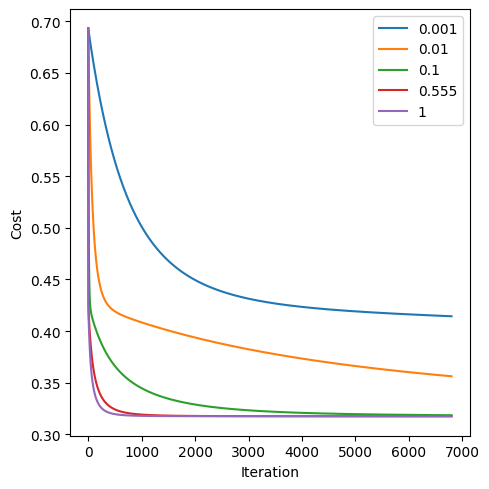

In [37]:
b = [i for i in range(0, 6800)]
fig, ax = plt.subplots(figsize=(5, 5))

for lr in (0.001, 0.01, 0.1, 0.555, 1):
  logistic_regression_model = model(X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized, iterations=6800, learning_rate=lr, print_cost=True, plot_iterations=True)
  a = [x for x in logistic_regression_model["costs"]]
  ax.plot(b, a, label=lr)

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
fig.tight_layout()
plt.savefig("iterationvcost.jpg")
plt.show()

##Tuning the Hyperparameters

In [ ]:
# Hyperparameter Tuning

# Define the hyperparameter values to search
#learning_rates = np.geomspace(0.0000001, 1, num=8) # to make the first search, then narrow down search space with linspace
learning_rates = np.linspace(0.1, 1, num=10)
#learning_rates = np.linspace(0.5, 0.6, num=10)
print(learning_rates)

iteration_values = [6800] # max_iter from https://wseas.com/journals/ps/2023/a165116-798.pdf

# Create an empty dictionary to store the results of the hyperparameter search
hyp_search_results = {}

# Perform hyperparameter search
for learn_rate in learning_rates:
    for iter_value in iteration_values:
        iter_value = int(iter_value)

        print(f"\nHyperparameter Search: Learning Rate = {learn_rate}, Iterations = {iter_value}")

        # Train the model with the current hyperparameters
        lr_model = model(X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized,
                         iterations=iter_value, learning_rate=learn_rate, print_cost=True)

        # Store the results in the hyp_search_results dictionary
        key = f"LR_{learn_rate}_Iter_{iter_value}"
        hyp_search_results[key] = {
            "learning_rate": learn_rate,
            "iterations": iter_value,
            "train_accuracy": 100 - np.mean(np.abs(lr_model["Y_prediction_train"] - y_train_normalized)) * 100,
            "test_accuracy": 100 - np.mean(np.abs(lr_model["Y_prediction_test"] - y_test_normalized)) * 100
        }

# Display the results of the hyperparameter search
print("\nHyperparameter Search Results:")
for key, result in hyp_search_results.items():
    print(f"{key}: Train Accuracy = {result['train_accuracy']:.5f}%, Test Accuracy = {result['test_accuracy']:.5f}%")

# Identify the best hyperparameters based on test accuracy
best_params = max(hyp_search_results, key=lambda k: hyp_search_results[k]["test_accuracy"])
best_learning_rate = hyp_search_results[best_params]["learning_rate"]
best_iterations = hyp_search_results[best_params]["iterations"]

print(f"\nBest Hyperparameters: Learning Rate = {best_learning_rate}, Iterations = {best_iterations}")

# Train the final model with the best hyperparameters
best_model = model(X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized,
                   iterations=best_iterations, learning_rate=best_learning_rate, print_cost=True)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

Hyperparameter Search: Learning Rate = 0.1, Iterations = 6800
train accuracy: 88.20894156090844 %
test accuracy: 88.17066771514592 %

Hyperparameter Search: Learning Rate = 0.2, Iterations = 6800
train accuracy: 88.40740896632614 %
test accuracy: 88.38667194098117 %

Hyperparameter Search: Learning Rate = 0.30000000000000004, Iterations = 6800
train accuracy: 88.44505412588575 %
test accuracy: 88.43169072617141 %

Hyperparameter Search: Learning Rate = 0.4, Iterations = 6800
train accuracy: 88.45680725393082 %
test accuracy: 88.44651325917944 %

Hyperparameter Search: Learning Rate = 0.5, Iterations = 6800
train accuracy: 88.46120565885096 %
test accuracy: 88.45280738219691 %

Hyperparameter Search: Learning Rate = 0.6, Iterations = 6800
train accuracy: 88.46313790481832 %
test accuracy: 88.45614316240639 %

Hyperparameter Search: Learning Rate = 0.7000000000000001, Iterations = 6800
train accuracy: 88.46409122676633 %
test accuracy: 88.458229

##Plotting

In [ ]:
# Reverse the normalization to get the original data
Y_prediction_test_real_scale = scaler.inverse_transform(best_model["Y_prediction_test"])
plot_df = pd.DataFrame(y_test)
plot_df["prediction"] = Y_prediction_test_real_scale.T

plot_df = plot_df.sort_index()

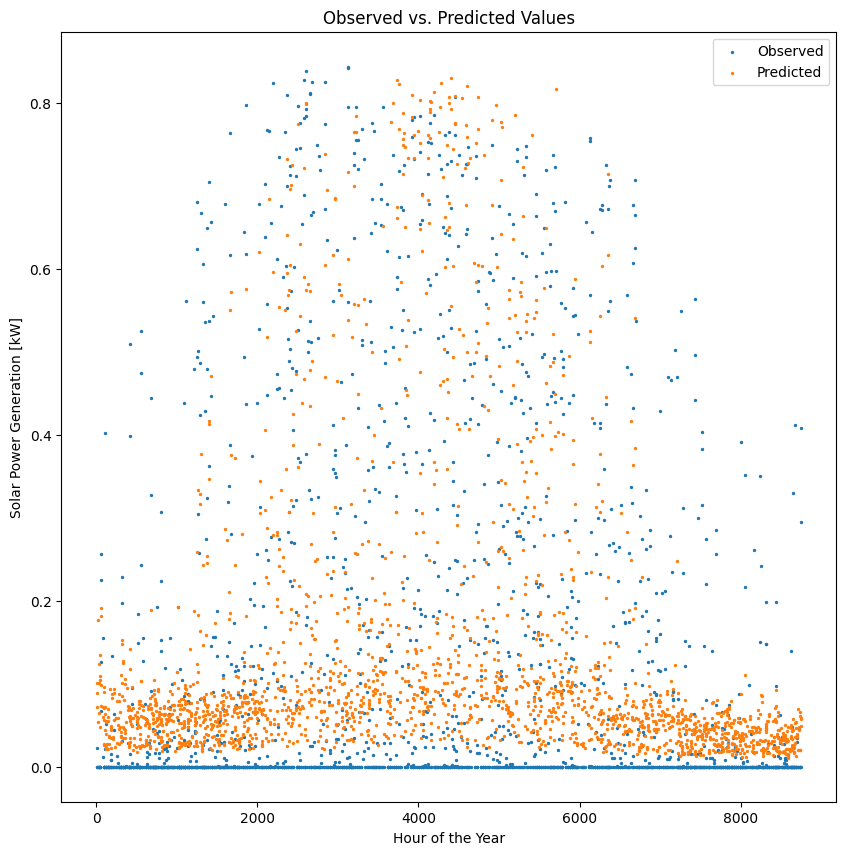

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot actual values
ax.scatter(plot_df.index, plot_df["electricity [kW]"], label='Observed', s=2)

# Plot predicted values
ax.scatter(plot_df.index, plot_df["prediction"], label='Predicted', s=2)

plt.xlabel('Hour of the Year')
plt.ylabel('Solar Power Generation [kW]')
plt.title('Observed vs. Predicted Values')
plt.legend()

plt.savefig("Logistic Regression scatter.jpg")
plt.show()

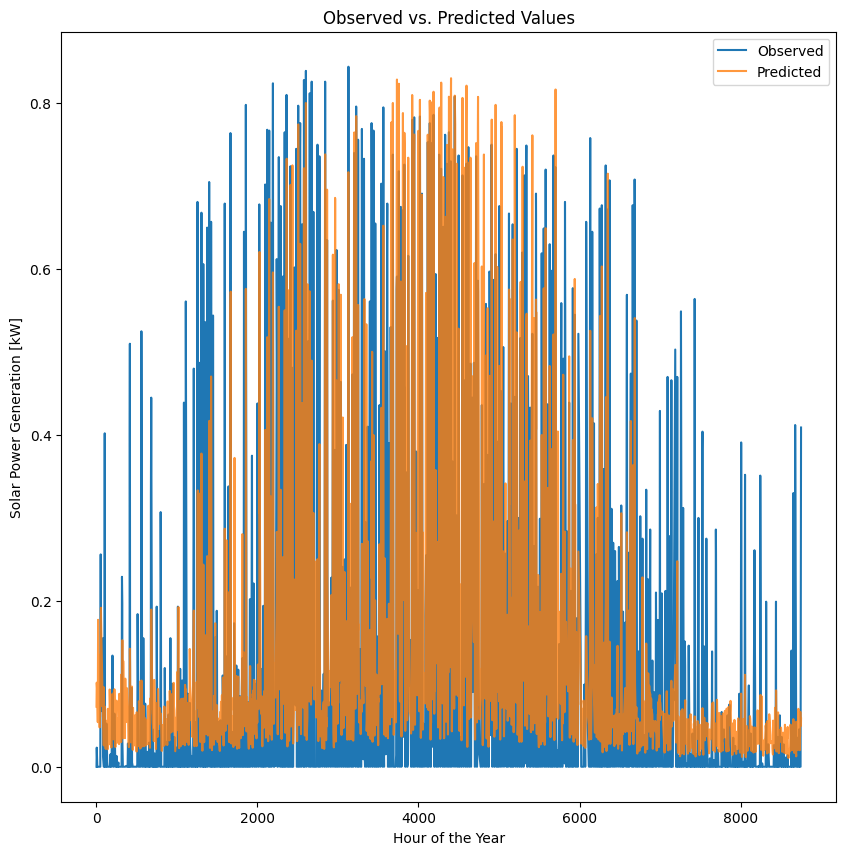

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot actual values
ax.plot(plot_df["electricity [kW]"], label='Observed')

# Plot predicted values
ax.plot(plot_df["prediction"], label='Predicted', alpha=0.8)

plt.xlabel('Hour of the Year')
plt.ylabel('Solar Power Generation [kW]')
plt.title('Observed vs. Predicted Values')
plt.legend()

plt.savefig("Logistic Regression line.jpg")
plt.show()

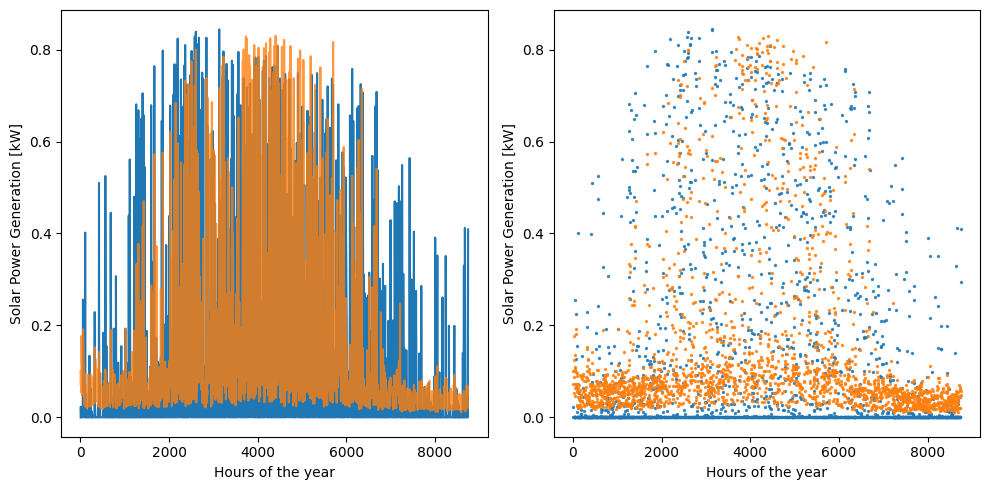

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))


# Plot actual values
ax2.scatter(plot_df.index, plot_df["electricity [kW]"], label='Observed', s=2, alpha=0.8)

# Plot predicted values
ax2.scatter(plot_df.index, plot_df["prediction"], label='Predicted', s=2, alpha=0.8)


# Plot actual values
ax1.plot(plot_df["electricity [kW]"], label='Observed')

# Plot predicted values
ax1.plot(plot_df["prediction"], label='Predicted', alpha=0.8)

ax1.set_xlabel('Hours of the year')
ax1.set_ylabel('Solar Power Generation [kW]')
ax2.set_xlabel('Hours of the year')
ax2.set_ylabel('Solar Power Generation [kW]')



fig.tight_layout()
plt.savefig("Logistic Regression subplot.jpg")
plt.show()

<Axes: xlabel='electricity [kW]', ylabel='Count'>

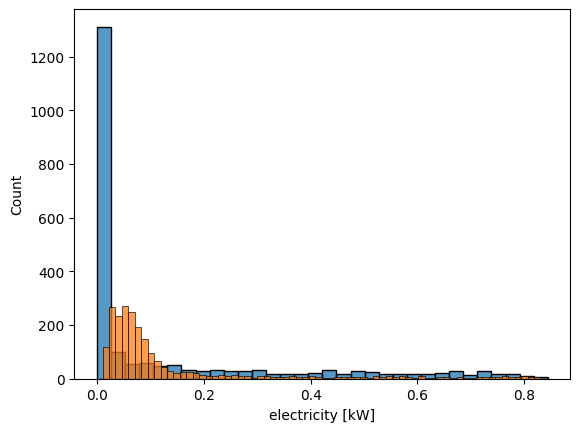

In [ ]:
import seaborn as sns
sns.histplot(plot_df["electricity [kW]"])
sns.histplot(plot_df["prediction"])